In [1]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import seaborn as sns

base_path = '/home/maj/data/insideairbnb/processed/'
train = pd.read_csv(base_path + 'train.csv', low_memory=False)
validate = pd.read_csv(base_path + 'validate.csv', low_memory=False)
test = pd.read_csv(base_path + 'test.csv', low_memory=False)
train_validate = pd.concat([train, validate])

train_validate.describe()

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bedrooms,minimum_nights,number_of_reviews,review_scores_rating,instant_bookable,...,house_rules_p,review_len,review_spec,review_num,svd_R,review_p,review_s,if_monthly,distance_min,price_log
count,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,...,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000
mean,0.432058,0.000776,0.997301,0.457991,0.001416,0.003226,-0.000436,0.000838,0.004530,0.546703,...,0.000111,-0.000343,-0.006913,-0.004571,0.005599,0.002076,0.001881,-0.007906,-0.003711,4.855212
std,0.495391,0.999817,0.051884,0.498261,1.001676,1.003955,1.013899,1.005067,0.982705,0.497843,...,1.000088,0.993335,0.956155,0.990426,0.992535,0.993063,0.992220,0.986144,0.999398,0.698210
min,0.000000,-0.243628,0.000000,0.000000,-1.435661,-1.621742,-0.246156,-0.634275,-12.209914,0.000000,...,-6.169202,-2.179418,-1.110441,-0.884758,-6.420100,-8.742889,-5.402021,-0.266410,-1.065591,2.302585
25%,0.000000,-0.238199,1.000000,0.000000,-0.937338,-0.481991,-0.246156,-0.590649,-0.080458,0.000000,...,-0.527809,-0.495224,-0.254877,-0.489322,-0.317731,-0.263927,-0.196427,-0.266410,-0.557558,4.369448
50%,0.000000,-0.232771,1.000000,0.000000,0.059306,-0.481991,-0.182337,-0.401604,0.242994,1.000000,...,-0.527809,0.004908,-0.142047,-0.108233,0.009905,-0.000321,0.029038,-0.266410,-0.323735,4.828314
75%,1.000000,-0.194770,1.000000,1.000000,1.055951,0.657761,-0.118518,0.150989,0.566446,1.000000,...,0.405026,0.297912,-0.011113,0.135818,0.502167,0.372443,0.394104,-0.266410,0.122526,5.298317
max,1.000000,9.636534,1.000000,1.000000,2.052595,4.077015,50.745168,11.275558,0.728172,1.000000,...,6.523932,18.193288,28.370835,19.118522,4.899802,5.618845,4.126983,3.753609,6.003178,6.906755


In [2]:
drop_columns = ['price_log', 'host_has_profile_pic', 'is_business_travel_ready', 'distance_to_san_diego_zoo']
X_train = train.drop(drop_columns, axis=1).to_numpy()
X_validate = validate.drop(drop_columns, axis=1).to_numpy()

# https://www.tensorflow.org/tutorials/keras/regression
# https://stackoverflow.com/questions/55924789/normalization-of-input-data-in-keras

# need to 'pickle' model creation to allow for multiprocess parallel execution for grid search
# see https://github.com/keras-team/keras/issues/6862
def create_model(neurons):
    m = keras.Sequential([
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='relu', input_shape=[X_train.shape[1]]),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='relu'),
        layers.Dropout(0.2),
        layers.BatchNormalization(),
        layers.Dense(neurons, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1)
    ])
    m.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse']) # also sgd, keras.optimizers.RMSprop
    return m


# test the model
m = create_model(32)
m.fit(X_train,
    train.price_log.to_numpy(),
    epochs=100,
    batch_size=32,
    validation_data=(X_validate, validate.price_log.to_numpy()),
    verbose = 1)
m.summary()

Train on 7243 samples, validate on 1279 samples
Epoch 1/100
7243/7243 [==============================] - 4s 510us/sample - loss: 14.6676 - mae: 3.5879 - mse: 14.6676 - val_loss: 3.2281 - val_mae: 1.6496 - val_mse: 3.2281
Epoch 2/100
7243/7243 [==============================] - 2s 284us/sample - loss: 1.3394 - mae: 0.9019 - mse: 1.3394 - val_loss: 0.4949 - val_mae: 0.5286 - val_mse: 0.4949
Epoch 3/100
7243/7243 [==============================] - 2s 297us/sample - loss: 0.5922 - mae: 0.6007 - mse: 0.5922 - val_loss: 0.3447 - val_mae: 0.4418 - val_mse: 0.3447
Epoch 4/100
7243/7243 [==============================] - 2s 301us/sample - loss: 0.4529 - mae: 0.5259 - mse: 0.4529 - val_loss: 0.2759 - val_mae: 0.4024 - val_mse: 0.2759
Epoch 5/100
7243/7243 [==============================] - 2s 296us/sample - loss: 0.4021 - mae: 0.4930 - mse: 0.4021 - val_loss: 0.2505 - val_mae: 0.3823 - val_mse: 0.2505
Epoch 6/100
7243/7243 [==============================] - 2s 294us/sample - loss: 0.3480 - mae: 

7243/7243 [==============================] - 2s 296us/sample - loss: 0.1712 - mae: 0.3146 - mse: 0.1712 - val_loss: 0.1609 - val_mae: 0.3085 - val_mse: 0.1609
Epoch 49/100
7243/7243 [==============================] - 2s 297us/sample - loss: 0.1727 - mae: 0.3157 - mse: 0.1727 - val_loss: 0.1601 - val_mae: 0.3078 - val_mse: 0.1601
Epoch 50/100
7243/7243 [==============================] - 2s 293us/sample - loss: 0.1740 - mae: 0.3172 - mse: 0.1740 - val_loss: 0.1539 - val_mae: 0.2942 - val_mse: 0.1539
Epoch 51/100
7243/7243 [==============================] - 2s 278us/sample - loss: 0.1713 - mae: 0.3152 - mse: 0.1713 - val_loss: 0.1553 - val_mae: 0.3017 - val_mse: 0.1553
Epoch 52/100
7243/7243 [==============================] - 2s 295us/sample - loss: 0.1656 - mae: 0.3085 - mse: 0.1656 - val_loss: 0.1500 - val_mae: 0.2892 - val_mse: 0.1500
Epoch 53/100
7243/7243 [==============================] - 2s 291us/sample - loss: 0.1661 - mae: 0.3089 - mse: 0.1661 - val_loss: 0.1537 - val_mae: 0.2984

Epoch 96/100
7243/7243 [==============================] - 2s 296us/sample - loss: 0.1560 - mae: 0.3014 - mse: 0.1560 - val_loss: 0.1510 - val_mae: 0.2911 - val_mse: 0.1510
Epoch 97/100
7243/7243 [==============================] - 2s 291us/sample - loss: 0.1540 - mae: 0.2982 - mse: 0.1540 - val_loss: 0.1433 - val_mae: 0.2889 - val_mse: 0.1433
Epoch 98/100
7243/7243 [==============================] - 2s 291us/sample - loss: 0.1497 - mae: 0.2942 - mse: 0.1497 - val_loss: 0.1418 - val_mae: 0.2831 - val_mse: 0.1418
Epoch 99/100
7243/7243 [==============================] - 2s 288us/sample - loss: 0.1525 - mae: 0.2958 - mse: 0.1525 - val_loss: 0.1384 - val_mae: 0.2811 - val_mse: 0.1384
Epoch 100/100
7243/7243 [==============================] - 2s 293us/sample - loss: 0.1542 - mae: 0.2986 - mse: 0.1542 - val_loss: 0.1426 - val_mae: 0.2867 - val_mse: 0.1426
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape            

In [3]:
%%time
grid = GridSearchCV(estimator=KerasRegressor(build_fn=create_model, verbose=0),
                    param_grid=dict(neurons=[16, 32, 48, 64, 96, 128, 144]),
                    n_jobs=1) # OOM if set 2?

grid_result = grid.fit(X_train,
                       train.price_log.to_numpy(),
                       epochs=500,
                       batch_size=64,
                       validation_data=(X_validate, validate.price_log.to_numpy()),
)

CPU times: user 6h 46min 5s, sys: 28min 57s, total: 7h 15min 2s
Wall time: 4h 19min 53s


In [4]:
m = grid_result.best_estimator_.model
grid_result.best_params_

{'neurons': 64}

In [5]:
X_test = test.drop(drop_columns, axis=1).to_numpy()
m.evaluate(X_test, test.price_log.to_numpy())

1504/1504 [==============================] - 0s 210us/sample - loss: 0.1439 - mae: 0.2844 - mse: 0.1439


[0.1438679203708121, 0.2844427, 0.14386792]

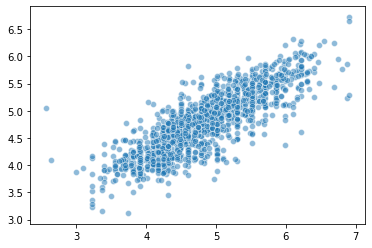

In [6]:
import seaborn as sns
sns.scatterplot(x=test.price_log.to_numpy(), y=m.predict(X_test).flatten(), alpha=0.5)

In [7]:
X_train.shape

(7243, 74)